# Méthode taboue

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from time import process_time
import random

In [107]:
# taille de la matrice : nombre de client + 1 (0: dépot) mij i->j
matrice_example = np.matrix([[0, 14, 18, 9, 5, 7], 
           [14, 0, 12, 4, 17, 1],
           [18, 12, 0, 3, 2, 1],
           [9, 4, 3, 0, 4, 8],
           [5, 17, 2, 4, 0, 11],
           [7, 1, 1, 8, 11, 0]])

In [108]:
sol_example = [[[1, 2], [5]], [[3, 4]]]

In [109]:
from itertools import combinations as comb
from copy import deepcopy

In [110]:
sol_example = [[1, 2, 5], [4, 3]]
sol_example2 = [[1, 3, 5], [2, 4]]
def cout(solution, matrice, w):
    K = len(solution) - solution.count([])
    sum_cost = 0
    for route in solution:
        if (len(route)):
            sum_cost += matrice[0, route[0]] # ajouter 0->premier el
            sum_cost += matrice[0, route[-1]] # ajouter dernier el->0
            for i in range(len(route)-1):
                sum_cost += matrice[route[i], route[i+1]]
    return K*w + sum_cost

(cout(sol_example, matrice_example, 18),cout(sol_example2, matrice_example, 18))

(88, 94)

In [111]:
def compute_capacities(route, capacities):
    total = 0
    for i in route:
        total += capacities[i-1]
    return total

def capacity_compatible(sol, capacities, max_capacity):
    for route in sol:
        total = compute_capacities(route, capacities)
        if (total > max_capacity):
            return False
    return True

max_capacity = 100
capacities_example = [20, 40, 50, 70, 30] # capacities for client n° 1, 2, 3, 4, 5
capacity_compatible([[1, 2, 5], [4, 3]],capacities_example, max_capacity)
capacity_compatible([[1, 2], [4, 5], [3]],capacities_example, max_capacity)

def filter_on_capacities(solutions, capacities, max_capacity):
    result = []
    for sol in solutions:
        if (capacity_compatible(sol[0], capacities, max_capacity)):
            result.append(sol)
    return result

filter_on_capacities([([[1, 2], [4, 5], [3]],15), ([[1, 2, 5], [4, 3]],25)],capacities_example, max_capacity)

[([[1, 2], [4, 5], [3]], 15)]

In [112]:
tabu_list = []
def acceptable(tabu_list, movement, current_sol_cost, prev_sol_cost, aspiration):
    if (not (current_sol_cost - prev_sol_cost <= aspiration)):
        return False
    else:
        if (movement in tabu_list):
            return False
        else:
            # tabu_list.append(movement) # mettre un max ?
            return True


In [113]:
tabu_list = []
def exchange(solution, matrice, w, tabu_list, aspiration, capacities, max_capacity):
    neighbours = []
    sol_cost = cout(solution, matrice, w)
    for combinaison in list(comb(enumerate(solution), 2)):
        for i in combinaison[0][1]:
            for j in combinaison[1][1]:
                tmp_sol = deepcopy(solution)
                pair0 = deepcopy(combinaison[0][1])     
                pair1 = deepcopy(combinaison[1][1])
                ind0 = combinaison[0][0]
                ind1 = combinaison[1][0]
                pair0.insert(pair0.index(i), j)
                pair0.remove(i)
                pair1.insert(pair1.index(j), i)
                pair1.remove(j)
                tmp_sol[ind0] = pair0
                tmp_sol[ind1] = pair1
                tmp_cost = cout(tmp_sol, matrice, w)
                # on définit un mouvement, par ("type d'opération", "index de la première paire", "index de la seconde paire", "élément 1 changé", "élément 2 changé")
                movement = (0, ind0, ind1, i, j)
                if(acceptable(tabu_list, movement, tmp_cost, sol_cost, aspiration)):
                    neighbours.append((tmp_sol,movement,tmp_cost))
                    
    neighbours = filter_on_capacities(neighbours, capacities, max_capacity)

    return neighbours
capacities_example = [20, 40, 50, 70, 30]
exchange(sol_example, matrice_example, 18, tabu_list, 5, capacities_example, max_capacity)  


[]

In [114]:
tabu_list = []
def flatten(t):
    return [item for sublist in t for item in sublist]
def relocate(solution, matrice, w, tabu_list, aspiration, capacities, max_capacity):
    neighbours = []
    sol_cost = cout(solution, matrice, w)
    combinations = list(comb(enumerate(solution), 2))
    

    for combinaison in combinations: 
        if (len(combinaison[0][1]) == 0):
            for j in combinaison[1][1]:
                tmp_sol = deepcopy(solution)
                pair0 = deepcopy(combinaison[0][1])     
                pair1 = deepcopy(combinaison[1][1])
                ind0 = combinaison[0][0]
                ind1 = combinaison[1][0]
                pair1.remove(j)
                pair0.insert(0, j)
                tmp_sol[ind0] = pair0
                tmp_sol[ind1] = pair1
                tmp_cost = cout(tmp_sol, matrice, w)
                # on définit un mouvement, par ("type d'opération", "index de la première paire", "index de la seconde paire", "index de là où on place le nouvel élément", "élément deplacé")
                movement = (1, ind0, ind1, 0, j)
                if(acceptable(tabu_list, movement, tmp_cost, sol_cost, aspiration)):
                    neighbours.append((tmp_sol, movement,tmp_cost))

        for i in combinaison[0][1]:
            for j in combinaison[1][1]:
                tmp_sol = deepcopy(solution)
                pair0 = deepcopy(combinaison[0][1])     
                pair1 = deepcopy(combinaison[1][1])
                ind0 = combinaison[0][0]
                ind1 = combinaison[1][0]
                pair1.remove(j)
                pair0.insert(pair0.index(i) + 1, j)
                tmp_sol[ind0] = pair0
                tmp_sol[ind1] = pair1
                tmp_cost = cout(tmp_sol, matrice, w)
                # on définit un mouvement, par ("type d'opération", "index de la première paire", "index de la seconde paire", "index de là où on place le nouvel élément", "élément deplacé")
                movement = (1, ind0, ind1, pair0.index(i) + 1, j)
                if(acceptable(tabu_list, movement, tmp_cost, sol_cost, aspiration)):
                    neighbours.append((tmp_sol, movement,tmp_cost))

        if (len(combinaison[1][1]) == 0):
            for j in combinaison[0][1]:
                tmp_sol = deepcopy(solution)
                pair0 = deepcopy(combinaison[1][1])     
                pair1 = deepcopy(combinaison[0][1])
                ind0 = combinaison[1][0]
                ind1 = combinaison[0][0]
                pair1.remove(j)
                pair0.insert(0, j)
                tmp_sol[ind0] = pair0
                tmp_sol[ind1] = pair1
                tmp_cost = cout(tmp_sol, matrice, w)
                # on définit un mouvement, par ("type d'opération", "index de la première paire", "index de la seconde paire", "index de là où on place le nouvel élément", "élément deplacé")
                movement = (1, ind0, ind1, 0, j)
                if(acceptable(tabu_list, movement, tmp_cost, sol_cost, aspiration)):
                    neighbours.append((tmp_sol, movement, tmp_cost))

        for i in combinaison[1][1]:
            for j in combinaison[0][1]:
                tmp_sol = deepcopy(solution)
                pair0 = deepcopy(combinaison[1][1])     
                pair1 = deepcopy(combinaison[0][1])
                ind0 = combinaison[1][0]
                ind1 = combinaison[0][0]
                pair1.remove(j)
                pair0.insert(pair0.index(i) + 1, j)
                tmp_sol[ind0] = pair0
                tmp_sol[ind1] = pair1
                tmp_cost = cout(tmp_sol, matrice, w)
                # on définit un mouvement, par ("type d'opération", "index de la première paire", "index de la seconde paire", "index de là où on place le nouvel élément", "élément deplacé")
                movement = (1, ind0, ind1, pair0.index(i) + 1, j)
                if(acceptable(tabu_list, movement, tmp_cost, sol_cost, aspiration)):
                    neighbours.append((tmp_sol, movement, tmp_cost))
        # à ce stade, il y a des redondances du fait des listes vides, mais vu qu'on va utiliser le max, on va avoir qu'une solution unique même si elles ont le mêmes coûts

    if (len(neighbours)):
        neighbours = filter_on_capacities(neighbours, capacities, max_capacity)

        # il serait peut-être nécessaire d'ajouter une fonction pour pouvoir explorer la solution avec ajout d'un camion à coup sûr
        if (len(neighbours) == 0):
            tmp_sol = deepcopy(solution)
            tmp_sol.append([])
            neighbours = relocate(tmp_sol, matrice, w, tabu_list, aspiration, capacities, max_capacity)
    
    return neighbours
capacities_example = [20, 40, 50, 70, 30]
max_capacity = 100
relocate([[1, 2, 5], [4, 3]], matrice_example, 18, tabu_list, 100, capacities_example, max_capacity)

[([[1, 2, 5], [3], [4]], (1, 2, 1, 0, 4), 116),
 ([[1, 2, 5], [4], [3]], (1, 2, 1, 0, 3), 116)]

In [115]:
tabu_list = []
def inverser(L,i,j):
    M=L.copy()
    M[j], M[i] = L[i], L[j]
    return M
def all_permutations(L):
    V=[]
    l=len(L)
    for i in range (l):
        for j in range (i+1,l):
            V.append(inverser(L,i,j))
    return(V)
def exchange_inside(solution, matrice, w, tabu_list, aspiration, capacities, max_capacity):
    if (not capacity_compatible(solution, capacities, max_capacity)):
        return []
    neighbours = []
    sol_cost = cout(solution, matrice, w)
    
    for i in range(len(solution)):
        route = solution[i]
        for permut in all_permutations(route):
            tmp_sol = deepcopy(solution)
            tmp_sol[i] = permut
            tmp_cost = cout(tmp_sol, matrice, w)
            movement = (2, i, permut)
            if(acceptable(tabu_list, movement, tmp_cost, sol_cost, aspiration)):
                    neighbours.append((tmp_sol, movement,tmp_cost))
        # à ce stade, il y a des redondances du fait des listes vides, mais vu qu'on va utiliser le max, on va avoir qu'une solution unique même si elles ont le mêmes coûts
    neighbours = filter_on_capacities(neighbours, capacities, max_capacity)
    
    return neighbours
capacities_example = [20, 40, 50, 70, 30]
max_capacity = 100
exchange_inside([[1, 2, 5], [4, 3], [], []], matrice_example, 18, tabu_list, 15, capacities_example, max_capacity) 

[]

In [116]:
LR = .85
Y = .9
def learn_Q(Q, s, s1, action, reward):
        # Fonction pour train la matrix Q, avec les donnes de l'action que on a decide.
        Q[s, action] = Q[s, action] + LR*(reward + Y * np.max(Q[s1, :]) - Q[s, action])
def take_action(st, Q, eps, action_nb):
    # Take an action
    if random.uniform(0, 1) < eps:
        #exploration
        action = random.randint(0, action_nb-1)
    else: # Or greedy action
        #exploitation
        action = np.argmax(Q[st])
    return action 

In [117]:
from voisinage import *

In [118]:
def tabu_old(sol_init, matrice, n_max, aspiration, w, capacities, max_capacity):
    start = process_time()

    actions = [intra_route_swap, inter_route_swap,intra_route_shift,two_intra_route_swap,two_intra_route_shift,del_small_route_w_capacity,del_random_route_w_capacity]
    action_nb = len(actions)
    Q = np.random.rand(action_nb, action_nb)
    generateVoisin=intra_route_swap
    state = 0
    
    cout_iter = []
    cout_best_iter = []
    temps_cout_iter = []
    nb_iter = []
    best_sol = sol_init
    best_sol_cost = np.inf
    current_sol = sol_init
    n_iter = 0
    tabu_list = []
    best_iter = 0
    while((n_iter - best_iter < n_max)):
        n_iter+=1
        #tmp = relocate(current_sol, matrice, w, tabu_list, aspiration, capacities, max_capacity) + exchange(current_sol, matrice, w, tabu_list, aspiration, capacities, max_capacity) + exchange_inside(current_sol, matrice, w, tabu_list, aspiration, capacities, max_capacity)
        #tmp.sort(key=lambda x: x[2])
        
        tmp_sol = deepcopy(current_sol)
        tmp = []
        
        new_state = take_action(state, Q, 0.8, action_nb)
        generateVoisin = actions[new_state]
        #print(generateVoisin, tmp_sol, capacities, max_capacity)
        tmp_sol = generateVoisin(tmp_sol, capacities, max_capacity)

        MAX_TRY_SOL = 2000
        MAX_TRY_METHOD = 1000

        try_k_method = 0
        try_k_sol = 0
        
        while ((tmp_sol in tabu_list) and (try_k_sol < MAX_TRY_SOL) and (cout(tmp_sol, matrice, w) > best_sol_cost-aspiration)):
            #print((tmp_sol in tabu_list), (try_k_method < MAX_TRY_METHOD), (cout(tmp_sol, matrice, w) > best_sol_cost-aspiration))
            try_k_sol += 1
            if (try_k_method < MAX_TRY_METHOD):
                try_k_method += 1
                tmp_sol = deepcopy(current_sol)
                tmp_sol = generateVoisin(tmp_sol, capacities, max_capacity)
            else:
                try_k_method = 0
                new_state = take_action(state, Q, 0.8, action_nb)
                generateVoisin = actions[new_state]
                tmp_sol = deepcopy(current_sol)
                tmp_sol = generateVoisin(tmp_sol, capacities, max_capacity)

        state = new_state
        learn_Q(Q, state, new_state, new_state, 2)

        
        
        if (try_k_sol < MAX_TRY_SOL):
            tmp.append(tmp_sol)

        if (len(tmp)):
            current_sol = tmp[0]
            current_sol_cost = cout(current_sol, matrice, w)
            temps_cout_iter.append(process_time() - start)
            tabu_list.append(tmp[0])
        else:
            break
        if (current_sol_cost < best_sol_cost):
            best_sol = current_sol
            best_iter = n_iter
            best_sol_cost = cout(best_sol, matrice, w)

        cout_iter.append(current_sol_cost)
        nb_iter.append(n_iter)
        cout_best_iter.append(best_sol_cost)
        
    # plot1 : coût par itération 
    #plt.subplot(1,2,1)
    plt.plot(nb_iter, cout_iter, 'b-', label="Cout_iter")
    plt.legend()
    plt.title("Coût TB par iteration")
    plt.xlabel("N. Iteration", fontsize=10)
    plt.xticks(rotation=90, fontsize=7)

    plt.ylabel("Coût")
    plt.show()    

    # plot2 : coût optimal par itération  
    #plt.subplot(1,2,2)      
    plt.plot(nb_iter, cout_best_iter, 'r-', label="Best_Cout")
    plt.legend()
    plt.title("Coût optimal TB par iteration")
    plt.xlabel("N. Iteration")
    plt.xticks(rotation=90, fontsize=7)
    plt.ylabel("Coût optimal")
    plt.show() 

    #plot3: temps par cout courrent
    plt.plot(temps_cout_iter, cout_iter,'g-', label="Cout-Temps")
    plt.legend()
    plt.title("Temps pour trouver la solution courante TB")
    plt.xlabel("Temps")
    plt.xticks(rotation=90, fontsize=7)
    plt.ylabel("Coût")
    plt.show() 

    #plot4: temps par cout optimal
    plt.plot(temps_cout_iter, cout_best_iter,'y-', label="Cout Optimal-Temps")
    plt.legend()
    plt.title("Temps pour trouver la solution optimale TB")
    plt.xlabel("Temps")
    plt.ylabel("Coût optimal")
    plt.xticks(rotation=90, fontsize=7)   
    plt.show() 

    return best_sol, cout(best_sol, matrice, w)
    


116
116
116
116
132
121
116
117
116
117
116
116
116


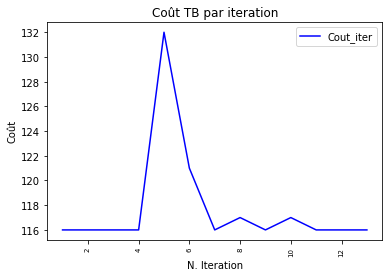

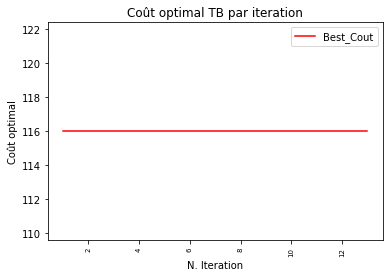

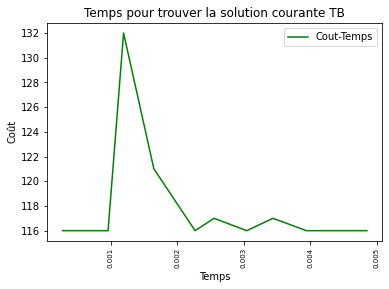

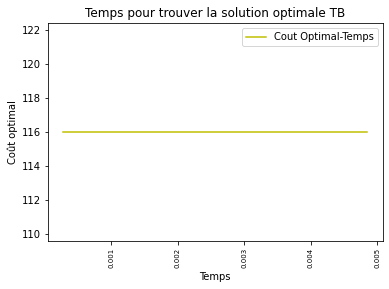

77
77
78
77
78
77
93
77
77
77
78
93
77
77
77
93
93
77
78
78
78
78
78


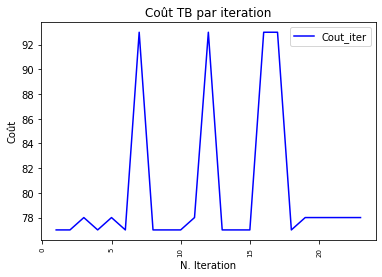

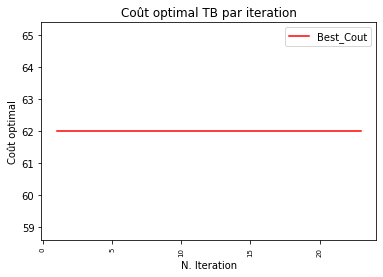

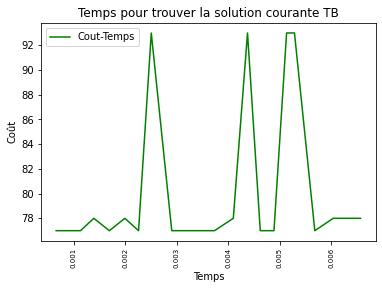

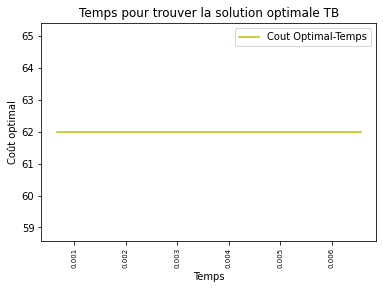

([[1, 2, 5], [4, 3]], 62)

In [119]:
def tabu(sol_init, matrice, n_max, aspiration, w, capacities, max_capacity):
    start = process_time()
    epsilon = 0.8
    actions = [relocate, exchange, exchange_inside]
    action_nb = len(actions)
    Q = np.random.rand(action_nb, action_nb)
    generateVoisin=relocate
    state = 0
    
    cout_iter = []
    cout_best_iter = []
    temps_cout_iter = []
    nb_iter = []
    best_sol = sol_init
    current_sol = sol_init
    n_iter = 0
    tabu_list = []
    best_iter = 0
    while((cout(current_sol, matrice, w) >= cout(best_sol, matrice, w)) and (n_iter - best_iter < n_max)):
        n_iter+=1

        tmp = []
        
        new_state = take_action(state, Q, epsilon, action_nb)
        if (epsilon > 0.1):
            epsilon -= 0.01
    
        generateVoisin = actions[new_state]
        #print(generateVoisin, tmp_sol, capacities, max_capacity)
        tmp = generateVoisin(current_sol, matrice, w, tabu_list, aspiration, capacities, max_capacity)

        tmp.sort(key=lambda x: x[2])
        
        state = new_state
        learn_Q(Q, state, new_state, new_state, 2)

        if (len(tmp)):
            current_sol = tmp[0][0]
            temps_cout_iter.append(process_time() - start)
            tabu_list.append(tmp[0][1])
            print(tmp[0][2])
        else:
            break
        if (cout(current_sol, matrice, w) < cout(best_sol, matrice, w)):
            best_sol = current_sol
            best_iter = n_iter

        cout_iter.append(cout(current_sol, matrice, w))
        nb_iter.append(n_iter)
        cout_best_iter.append(cout(best_sol, matrice, w))
        
    # plot1 : coût par itération 
    #plt.subplot(1,2,1)
    plt.plot(nb_iter, cout_iter, 'b-', label="Cout_iter")
    plt.legend()
    plt.title("Coût TB par iteration")
    plt.xlabel("N. Iteration", fontsize=10)
    plt.xticks(rotation=90, fontsize=7)
    plt.ylabel("Coût")
    plt.show()    

    # plot2 : coût optimal par itération  
    #plt.subplot(1,2,2)      
    plt.plot(nb_iter, cout_best_iter, 'r-', label="Best_Cout")
    plt.legend()
    plt.title("Coût optimal TB par iteration")
    plt.xlabel("N. Iteration")
    plt.xticks(rotation=90, fontsize=7)
    plt.ylabel("Coût optimal")
    plt.show() 

    #plot3: temps par cout courrent
    plt.plot(temps_cout_iter, cout_iter,'g-', label="Cout-Temps")
    plt.legend()
    plt.title("Temps pour trouver la solution courante TB")
    plt.xlabel("Temps")
    plt.xticks(rotation=90, fontsize=7)
    plt.ylabel("Coût")
    plt.show() 

    #plot4: temps par cout optimal
    plt.plot(temps_cout_iter, cout_best_iter,'y-', label="Cout Optimal-Temps")
    plt.legend()
    plt.title("Temps pour trouver la solution optimale TB")
    plt.xlabel("Temps")
    plt.ylabel("Coût optimal")
    plt.xticks(rotation=90, fontsize=7)  
    plt.show() 

    return best_sol, cout(best_sol, matrice, w)
    
tabu([[1, 2, 5], [4], [3], []], matrice_example, 1000, 1000, 18, capacities_example, max_capacity)
capacities_example = [20, 40, 50, 70, 30]
max_capacity = 100
tabu([[1, 2, 5], [4, 3]], matrice_example, 1000, 1000, 5, capacities_example, max_capacity) 

102
77
78
78
78
77
78
77
77
77
77
77
77
81
78
78
78


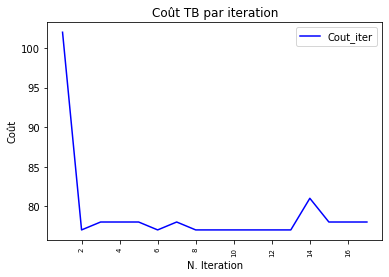

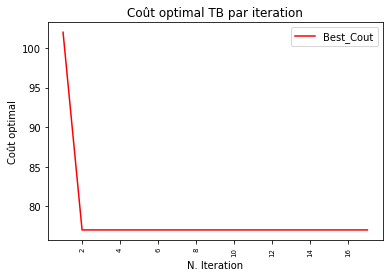

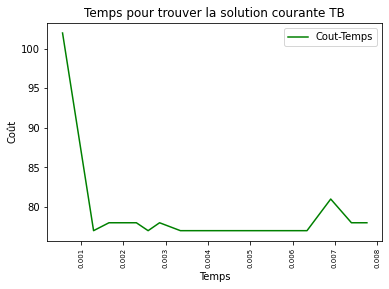

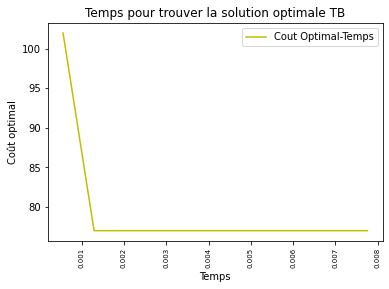

([[1, 5], [4], [2, 3], []], 77)

In [120]:
capacities_example = [20, 40, 50, 70, 30]
max_capacity = 100
tabu([[1], [4, 3], [2], [5]], matrice_example, 1000, 100, 5, capacities_example, max_capacity)

In [121]:
matrice_example2 =  np.matrix([
    [0, 14, 4, 5, 22, 6, 7, 9, 7, 7, 2, 13, 15, 12, 11, 17, 11, 4, 18, 9, 8, 10, 9, 25, 11, 20, 19, 23, 32, 21, 29, 34,
     20, 18, 27, 18, 21, 12, 9, 15, 11, 21, 23, 18, 16, 31, 23, 26, 21, 20, 12, 100],
    [14, 0, 12, 7, 9, 15, 18, 12, 11, 19, 7, 11, 9, 19, 21, 11, 16, 13, 19, 23, 17, 11, 22, 20, 11, 13, 11, 17, 8, 11,
     8, 29, 14, 7, 14, 12, 18, 19, 11, 21, 20, 15, 13, 18, 14, 29, 21, 17, 24, 21, 19, 31],
    [4, 12, 0, 11, 12, 17, 7, 6, 12, 9, 4, 17, 21, 8, 12, 15, 23, 22, 16, 14, 19, 10, 8, 5, 17, 11, 21, 25, 23, 22, 19,
     21, 21, 16, 15, 19, 29, 31, 16, 19, 11, 21, 20, 24, 19, 21, 22, 27, 29, 33, 16, 21],
    [5, 7, 11, 0, 8, 11, 16, 5, 9, 7, 12, 9, 11, 15, 19, 11, 14, 13, 17, 22, 29, 26, 19, 13, 16, 27, 25, 23, 11, 19, 21,
     8, 17, 10, 15, 18, 27, 23, 20, 16, 14, 19, 11, 13, 22, 21, 21, 30, 19, 27, 25, 14],
    [22, 9, 12, 8, 0, 7, 8, 4, 9, 14, 12, 11, 15, 17, 9, 15, 17, 11, 16, 10, 21, 30, 21, 16, 12, 11, 17, 13, 11, 19, 11,
     16, 9, 23, 21, 22, 14, 17, 13, 11, 14, 18, 24, 28, 29, 30, 21, 25, 16, 11, 17, 24],
    [6, 15, 17, 11, 7, 0, 6, 4, 6, 24, 11, 27, 15, 19, 21, 23, 12, 17, 19, 22, 14, 10, 22, 26, 21, 27, 16, 13, 14, 11,
     8, 6, 18, 11, 21, 27, 11, 29, 22, 12, 17, 8, 11, 21, 30, 12, 16, 29, 22, 11, 15, 19],
    [7, 18, 7, 16, 8, 6, 0, 12, 8, 15, 9, 22, 12, 11, 16, 9, 6, 12, 14, 21, 27, 11, 23, 26, 21, 25, 11, 10, 13, 9, 7,
     16, 15, 13, 19, 21, 22, 18, 13, 16, 12, 13, 19, 21, 22, 17, 21, 21, 29, 24, 19, 11],
    [9, 12, 6, 5, 4, 4, 12, 0, 12, 14, 4, 12, 7, 9, 12, 11, 16, 18, 14, 10, 21, 27, 11, 14, 16, 11, 19, 21, 28, 31, 21,
     22, 26, 16, 8, 11, 15, 24, 29, 21, 20, 16, 11, 9, 24, 22, 15, 18, 13, 16, 13, 16],
    [7, 11, 12, 9, 9, 6, 8, 12, 0, 21, 25, 17, 14, 6, 21, 9, 11, 19, 12, 17, 14, 21, 29, 16, 11, 12, 24, 11, 12, 15, 8,
     11, 23, 21, 35, 21, 22, 31, 29, 21, 17, 13, 8, 16, 15, 7, 21, 9, 15, 12, 22, 21],
    [7, 19, 9, 7, 14, 24, 15, 14, 21, 0, 12, 11, 6, 13, 11, 16, 12, 11, 8, 9, 12, 16, 19, 31, 25, 27, 12, 21, 20, 31,
     21, 26, 24, 21, 36, 22, 16, 7, 15, 13, 6, 17, 14, 8, 15, 17, 12, 11, 21, 27, 23, 20],
    [2, 7, 4, 12, 12, 11, 9, 4, 25, 12, 0, 6, 7, 16, 13, 9, 17, 13, 20, 25, 21, 11, 12, 16, 22, 21, 23, 29, 32, 10, 11,
     13, 16, 12, 6, 10, 32, 21, 19, 16, 11, 32, 21, 18, 14, 12, 14, 13, 8, 11, 23, 14],
    [13, 11, 17, 9, 11, 27, 22, 12, 17, 11, 6, 0, 9, 12, 13, 11, 14, 18, 21, 23, 22, 12, 10, 16, 12, 19, 9, 17, 7, 10,
     17, 13, 21, 17, 24, 16, 13, 20, 28, 21, 26, 21, 15, 19, 11, 12, 17, 21, 22, 11, 9, 17],
    [15, 9, 21, 11, 15, 15, 12, 7, 14, 6, 7, 9, 0, 21, 8, 13, 19, 27, 16, 13, 11, 21, 22, 28, 11, 13, 15, 9, 7, 13, 11,
     17, 19, 28, 14, 18, 14, 16, 15, 19, 16, 13, 16, 17, 13, 18, 11, 16, 19, 24, 28, 31],
    [12, 19, 8, 15, 17, 19, 11, 9, 6, 13, 16, 12, 21, 0, 21, 11, 20, 8, 6, 13, 12, 19, 23, 11, 14, 16, 11, 17, 16, 13,
     11, 10, 21, 22, 31, 26, 28, 23, 16, 14, 13, 10, 7, 13, 16, 13, 20, 25, 17, 25, 22, 13],
    [11, 21, 12, 19, 9, 21, 16, 12, 21, 11, 13, 13, 8, 21, 0, 9, 7, 11, 12, 11, 24, 21, 12, 16, 25, 21, 17, 14, 7, 10,
     14, 11, 14, 22, 31, 29, 21, 13, 15, 18, 11, 12, 17, 14, 12, 6, 11, 12, 23, 8, 4, 11],
    [17, 11, 15, 11, 15, 23, 9, 11, 9, 16, 9, 11, 13, 11, 9, 0, 11, 21, 21, 34, 22, 11, 12, 11, 11, 21, 14, 11, 13, 12,
     12, 13, 14, 16, 12, 21, 41, 22, 12, 12, 33, 11, 9, 14, 12, 12, 15, 13, 12, 14, 19, 21],
    [11, 16, 23, 14, 17, 12, 6, 16, 11, 12, 17, 14, 19, 20, 7, 11, 0, 9, 7, 10, 12, 16, 14, 14, 21, 32, 23, 17, 11, 37,
     21, 11, 13, 16, 11, 16, 10, 9, 17, 14, 15, 12, 21, 12, 16, 16, 14, 13, 15, 9, 5, 11],
    [4, 13, 22, 13, 11, 17, 12, 18, 19, 11, 13, 18, 27, 8, 11, 21, 9, 0, 12, 11, 14, 12, 21, 26, 21, 29, 21, 20, 21, 23,
     16, 12, 13, 18, 9, 21, 8, 12, 18, 7, 27, 21, 16, 13, 11, 21, 25, 28, 21, 13, 8, 10],
    [18, 19, 16, 17, 16, 19, 14, 14, 12, 8, 20, 21, 16, 6, 12, 21, 7, 12, 0, 16, 21, 14, 17, 11, 13, 9, 8, 10, 12, 17,
     14, 27, 21, 31, 22, 20, 21, 24, 25, 12, 17, 14, 6, 9, 18, 11, 15, 12, 17, 11, 12, 7],
    [9, 23, 14, 22, 10, 22, 21, 10, 17, 9, 25, 23, 13, 13, 11, 34, 10, 11, 16, 0, 12, 6, 12, 13, 18, 9, 6, 12, 10, 31,
     21, 11, 10, 7, 14, 17, 11, 19, 21, 11, 13, 18, 21, 22, 13, 14, 17, 11, 18, 10, 21, 11],
    [8, 17, 19, 29, 21, 14, 27, 21, 14, 12, 21, 22, 11, 12, 24, 22, 12, 14, 21, 12, 0, 7, 10, 8, 13, 11, 27, 21, 20, 11,
     17, 25, 27, 18, 21, 21, 18, 14, 8, 11, 9, 11, 8, 11, 14, 10, 12, 14, 11, 21, 9, 21],
    [10, 11, 10, 26, 30, 10, 11, 27, 21, 16, 11, 12, 21, 19, 21, 11, 16, 12, 14, 6, 7, 0, 21, 32, 11, 10, 8, 10, 12, 16,
     8, 19, 7, 12, 14, 16, 12, 11, 17, 23, 21, 25, 28, 31, 26, 13, 12, 16, 17, 12, 12, 11],
    [9, 22, 8, 19, 21, 22, 23, 11, 29, 19, 12, 10, 22, 23, 12, 12, 14, 21, 17, 12, 10, 21, 0, 10, 6, 17, 9, 10, 11, 16,
     12, 15, 17, 21, 11, 14, 12, 11, 26, 28, 22, 12, 11, 26, 13, 11, 11, 23, 8, 7, 19, 9],
    [25, 20, 5, 13, 16, 26, 26, 14, 16, 31, 16, 16, 28, 11, 16, 11, 14, 26, 11, 13, 8, 32, 10, 0, 12, 18, 15, 11, 11,
     17, 15, 12, 41, 9, 7, 10, 11, 15, 26, 21, 24, 15, 8, 12, 9, 13, 16, 12, 24, 11, 21, 27],
    [11, 11, 17, 16, 12, 21, 21, 16, 11, 25, 22, 12, 11, 14, 25, 11, 21, 21, 13, 18, 13, 11, 6, 12, 0, 11, 9, 11, 17,
     12, 14, 11, 21, 31, 12, 16, 11, 17, 12, 9, 7, 10, 9, 21, 14, 11, 13, 11, 21, 11, 10, 8],
    [20, 13, 11, 27, 11, 27, 25, 11, 12, 27, 21, 19, 13, 16, 21, 21, 32, 29, 9, 9, 11, 10, 17, 18, 11, 0, 8, 17, 15, 31,
     18, 11, 12, 16, 12, 17, 12, 21, 12, 14, 19, 12, 18, 11, 15, 14, 21, 18, 16, 12, 7, 12],
    [19, 11, 21, 25, 17, 16, 11, 19, 24, 12, 23, 9, 15, 11, 17, 14, 23, 21, 8, 6, 27, 8, 9, 15, 9, 8, 0, 21, 11, 11, 15,
     16, 12, 11, 14, 11, 19, 21, 14, 11, 19, 7, 9, 12, 15, 31, 21, 11, 21, 15, 17, 14],
    [23, 17, 25, 23, 13, 13, 10, 21, 11, 21, 29, 17, 9, 17, 14, 11, 17, 20, 10, 12, 21, 10, 10, 11, 11, 17, 21, 0, 10,
     9, 15, 11, 12, 6, 10, 21, 19, 8, 15, 14, 12, 10, 17, 9, 17, 12, 14, 16, 12, 17, 11, 22],
    [32, 8, 23, 11, 11, 14, 13, 28, 12, 20, 32, 7, 7, 16, 7, 13, 11, 21, 12, 10, 20, 12, 11, 11, 17, 15, 11, 10, 0, 9,
     12, 11, 12, 9, 10, 11, 12, 17, 9, 4, 15, 17, 15, 19, 11, 10, 9, 15, 16, 17, 15, 12],
    [21, 11, 22, 19, 19, 11, 9, 31, 15, 31, 10, 10, 13, 13, 10, 12, 37, 23, 17, 31, 11, 16, 16, 17, 12, 31, 11, 9, 9, 0,
     11, 21, 21, 17, 14, 21, 18, 11, 17, 13, 15, 11, 27, 10, 11, 12, 16, 14, 11, 12, 9, 8],
    [29, 8, 19, 21, 11, 8, 7, 21, 8, 21, 11, 17, 11, 11, 14, 12, 21, 16, 14, 21, 17, 8, 12, 15, 14, 18, 15, 15, 12, 11,
     0, 12, 13, 16, 9, 7, 11, 10, 7, 13, 11, 25, 11, 11, 15, 9, 7, 19, 8, 6, 10, 12],
    [34, 29, 21, 8, 16, 6, 16, 22, 11, 26, 13, 13, 17, 10, 11, 13, 11, 12, 27, 11, 25, 19, 15, 12, 11, 11, 16, 11, 11,
     21, 12, 0, 14, 9, 8, 21, 25, 32, 15, 11, 12, 10, 11, 15, 14, 8, 9, 19, 13, 12, 10, 11],
    [20, 14, 21, 17, 9, 18, 15, 26, 23, 24, 16, 21, 19, 21, 14, 14, 13, 13, 21, 10, 27, 7, 17, 41, 21, 12, 12, 12, 12,
     21, 13, 14, 0, 21, 13, 9, 6, 17, 8, 18, 7, 9, 10, 12, 12, 5, 14, 12, 12, 13, 11, 19],
    [18, 7, 16, 10, 23, 11, 13, 16, 21, 21, 12, 17, 28, 22, 22, 16, 16, 18, 31, 7, 18, 12, 21, 9, 31, 16, 11, 6, 9, 17,
     16, 9, 21, 0, 11, 13, 4, 9, 8, 15, 11, 12, 14, 11, 12, 18, 17, 11, 12, 14, 11, 12],
    [27, 14, 15, 15, 21, 21, 19, 8, 35, 36, 6, 24, 14, 31, 31, 12, 11, 9, 22, 14, 21, 14, 11, 7, 12, 12, 14, 10, 10, 14,
     9, 8, 13, 11, 0, 12, 10, 9, 4, 13, 11, 18, 25, 28, 29, 12, 11, 16, 18, 12, 10, 9],
    [18, 12, 19, 18, 22, 27, 21, 11, 21, 22, 10, 16, 18, 26, 29, 21, 16, 21, 20, 17, 21, 16, 14, 10, 16, 17, 11, 21, 11,
     21, 7, 21, 9, 13, 12, 0, 11, 8, 9, 16, 11, 10, 10, 11, 17, 16, 12, 7, 9, 14, 11, 7],
    [21, 18, 29, 27, 14, 11, 22, 15, 22, 16, 32, 13, 14, 28, 21, 41, 10, 8, 21, 11, 18, 12, 12, 11, 11, 12, 19, 19, 12,
     18, 11, 25, 6, 4, 10, 11, 0, 12, 8, 9, 13, 11, 5, 11, 12, 11, 16, 9, 10, 13, 7, 14],
    [12, 19, 31, 23, 17, 29, 18, 24, 31, 7, 21, 20, 16, 23, 13, 22, 9, 12, 24, 19, 14, 11, 11, 15, 17, 21, 21, 8, 17,
     11, 10, 32, 17, 9, 9, 8, 12, 0, 9, 11, 15, 22, 26, 21, 18, 12, 17, 16, 11, 12, 14, 11],
    [9, 11, 16, 20, 13, 22, 13, 29, 29, 15, 19, 28, 15, 16, 15, 12, 17, 18, 25, 21, 8, 17, 26, 26, 12, 12, 14, 15, 9,
     17, 7, 15, 8, 8, 4, 9, 8, 9, 0, 13, 18, 14, 11, 18, 13, 12, 16, 18, 15, 13, 11, 15],
    [15, 21, 19, 16, 11, 12, 16, 21, 21, 13, 16, 21, 19, 14, 18, 12, 14, 7, 12, 11, 11, 23, 28, 21, 9, 14, 11, 14, 4,
     13, 13, 11, 18, 15, 13, 16, 9, 11, 13, 0, 10, 17, 11, 13, 6, 9, 16, 11, 12, 11, 21, 24],
    [11, 20, 11, 14, 14, 17, 12, 20, 17, 6, 11, 26, 16, 13, 11, 33, 15, 27, 17, 13, 9, 21, 22, 24, 7, 19, 19, 12, 15,
     15, 11, 12, 7, 11, 11, 11, 13, 15, 18, 10, 0, 11, 5, 18, 9, 6, 12, 10, 9, 8, 11, 27],
    [21, 15, 21, 19, 18, 8, 13, 16, 13, 17, 32, 21, 13, 10, 12, 11, 12, 21, 14, 18, 11, 25, 12, 15, 10, 12, 7, 10, 17,
     11, 25, 10, 9, 12, 18, 10, 11, 22, 14, 17, 11, 0, 11, 15, 12, 25, 18, 13, 12, 16, 11, 12],
    [23, 13, 20, 11, 24, 11, 19, 11, 8, 14, 21, 15, 16, 7, 17, 9, 21, 16, 6, 21, 8, 28, 11, 8, 9, 18, 9, 17, 15, 27, 11,
     11, 10, 14, 25, 10, 5, 26, 11, 11, 5, 11, 0, 14, 15, 11, 8, 10, 8, 9, 11, 26],
    [18, 18, 24, 13, 28, 21, 21, 9, 16, 8, 18, 19, 17, 13, 14, 14, 12, 13, 9, 22, 11, 31, 26, 12, 21, 11, 12, 9, 19, 10,
     11, 15, 12, 11, 28, 11, 11, 21, 18, 13, 18, 15, 0, 0, 19, 11, 21, 9, 24, 11, 14, 11],
    [16, 14, 19, 22, 29, 30, 22, 24, 15, 15, 14, 11, 13, 16, 12, 12, 16, 11, 18, 13, 14, 26, 13, 9, 14, 15, 15, 17, 11,
     11, 15, 14, 12, 12, 29, 17, 12, 18, 13, 6, 9, 12, 0, 19, 0, 21, 6, 9, 11, 14, 8, 10],
    [31, 29, 21, 21, 30, 12, 17, 22, 7, 17, 12, 12, 18, 13, 6, 12, 16, 21, 11, 14, 10, 13, 11, 13, 11, 14, 31, 12, 10,
     12, 9, 8, 5, 18, 12, 16, 11, 12, 12, 9, 6, 25, 0, 11, 21, 0, 9, 7, 8, 13, 11, 21],
    [23, 21, 22, 21, 21, 16, 21, 15, 21, 12, 14, 17, 11, 20, 11, 15, 14, 25, 15, 17, 12, 12, 11, 16, 13, 21, 21, 14, 9,
     16, 7, 9, 14, 17, 11, 12, 16, 17, 16, 16, 12, 18, 0, 21, 6, 9, 0, 11, 14, 7, 9, 22],
    [26, 17, 27, 30, 25, 29, 21, 18, 9, 11, 13, 21, 16, 25, 12, 13, 13, 28, 12, 11, 14, 16, 23, 12, 11, 18, 11, 16, 15,
     14, 19, 19, 12, 11, 16, 7, 9, 16, 18, 11, 10, 13, 0, 9, 9, 7, 11, 0, 9, 14, 12, 12],
    [21, 24, 29, 19, 16, 22, 29, 13, 15, 21, 8, 22, 19, 17, 23, 12, 15, 21, 17, 18, 11, 17, 8, 24, 21, 16, 21, 12, 16,
     11, 8, 13, 12, 12, 18, 9, 10, 11, 15, 12, 9, 12, 0, 24, 11, 8, 14, 9, 0, 5, 15, 10],
    [20, 21, 33, 27, 11, 11, 24, 16, 12, 27, 11, 11, 24, 25, 8, 14, 9, 13, 11, 10, 21, 12, 7, 11, 11, 12, 15, 17, 17,
     12, 6, 12, 13, 14, 12, 14, 13, 12, 13, 11, 8, 16, 0, 11, 14, 13, 7, 14, 5, 0, 14, 7],
    [12, 19, 16, 25, 17, 15, 19, 13, 22, 23, 23, 9, 28, 22, 4, 19, 5, 8, 12, 21, 9, 12, 19, 21, 10, 7, 17, 11, 15, 9,
     10, 10, 11, 11, 10, 11, 7, 14, 11, 21, 11, 11, 0, 14, 8, 11, 9, 12, 15, 14, 0, 6],
    [100, 31, 21, 14, 24, 19, 11, 16, 21, 20, 14, 17, 31, 13, 11, 21, 11, 10, 7, 11, 21, 11, 9, 27, 8, 12, 14, 22, 12,
     8, 12, 11, 19, 12, 9, 7, 14, 11, 15, 24, 27, 12, 0, 11, 10, 21, 22, 12, 10, 7, 6, 0]])

669
601
558
523
498
464
445
442
441
434
431
418
405
401
399
398
395
386
384
380
379
380
381
379
380
379
380
379
382
383
380
379
380
382
380


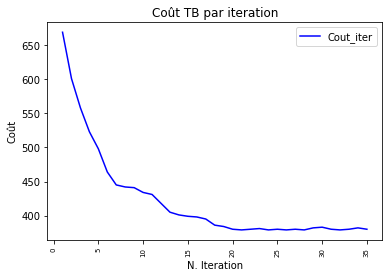

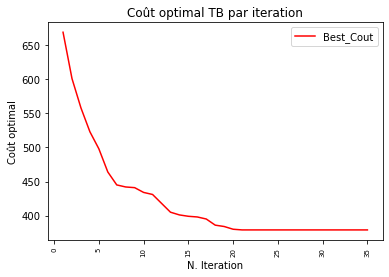

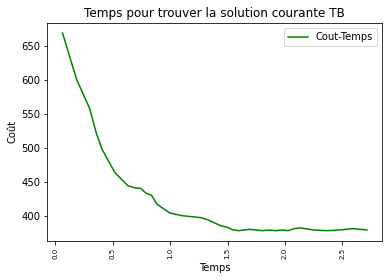

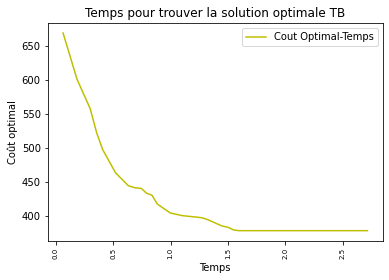

([[3, 1, 4, 8, 5, 7, 12, 10, 11, 50, 16, 6, 2],
  [22,
   48,
   49,
   25,
   31,
   46,
   44,
   39,
   28,
   29,
   37,
   27,
   33,
   36,
   38,
   34,
   23,
   20,
   21,
   19,
   26,
   41,
   32,
   45,
   14,
   15,
   30,
   35,
   47,
   43,
   9,
   40,
   24,
   51,
   42,
   18,
   13,
   17],
  [],
  [],
  [],
  [],
  [],
  []],
 379)

In [122]:
sol_example = [[3, 1, 8, 5, 7, 12, 10, 13, 42], [22, 2, 15, 11, 49, 16, 17, 39, 28, 29, 27, 33, 36, 38, 34, 23, 20, 21, 19, 26, 41, 32, 45, 14, 4, 6, 30, 35, 47, 43, 9, 40, 24, 50, 25, 51], [37], [48], [18], [31], [44], [46]]
capacities_example = [1]*51
max_capacity = 100
tabu(sol_example, matrice_example2, 100, 3, 5, capacities_example, max_capacity)

699
665
644
625
610
604
564
555
546
541
539
534
527
522
518
516
510
504
502
501
499
495
491
490
489
489
486
486
485
485
486
486
486
486
485
486
485
484
483
484
483
485
483
485
482
482
480
482
479
481
479
481
479
482
480
482
480
482
477
475
473
473
473
474
473
475
473
475
477
476
477
478
477
478
476
473
472
473
474
472
471
471
471
471
470
469
469
469
471
468
469
468
469
468
470
468
471
468
471
470
469
467
467
466
467
467
467
467
468
467
468
464
465
466
466
464
464
464
464
463
464
456
457
458
457
458
457
456
455
454
455
456
455
458
459
462
459
462
465
466
466
469
465
465
465
468
465


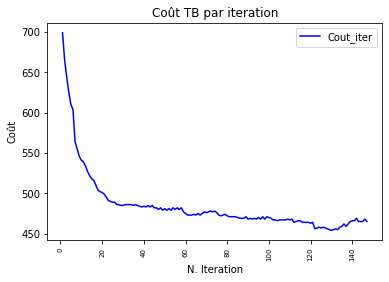

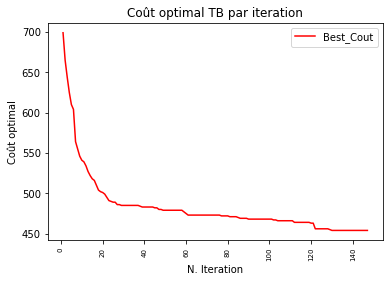

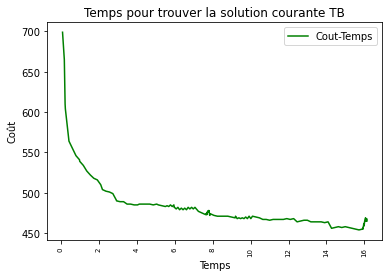

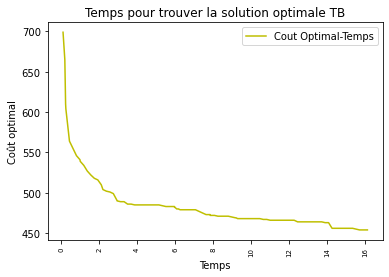

([[3, 4, 7, 12, 1, 30, 46, 49, 48, 42, 18, 13, 17],
  [38, 36, 33, 27, 37, 34, 23, 20, 21, 19],
  [2, 25, 50, 14, 16],
  [5, 31, 41, 26, 29, 15, 6],
  [],
  [9, 43, 47, 8],
  [22, 24, 51, 35, 32, 45, 40],
  [44, 39, 28, 11, 10]],
 454)

In [123]:
sol_example = [[3, 1, 8, 5, 7, 12, 10, 13, 42], [33, 36, 38, 34, 23, 20, 21, 19], [37, 47, 50, 25, 51], [48, 26, 41, 32, 45, 14], [18], [31, 43, 9, 40, 24], [44, 4, 6, 30, 35], [46, 22, 2, 15, 11, 49, 16, 17, 39, 28, 29, 27]]
capacities_example = [3]*51
max_capacity = 100
tabu(sol_example, matrice_example2, 100, 3, 5, capacities_example, max_capacity)